# 神经网络的可视化
理解了张量的运算过程，基本上就大致可以了解神经网络的工作原理的。但是这个`理解`还是一个非常抽象的。幸运的是，我们可以通过`可视化`的方式来更好的理解这个过程。神经网络的可视化大致可以分为以下三个部分：
- 可视化神经网络的中间输出（中间激活）:将每一层的中间输出可视化展示出来。
- 可视化神经网络的过滤器（卷积核）:帮助理解网络中每个过滤器最容易接收的视觉模式
- 可视化图像中的激活热力图
# 可视化神经网络的中间输出
- 第一层是各种边缘的检测器，在这一层中几乎保留了图片中所有的信息
- 随着层数的加深，激活变得越来越抽象，并且难以理解，它们开始尝试表达高层次的概念，比如猫耳朵，猫眼睛，猫嘴，猫脸等等。关于图像的视觉内容变得越来越少，关于图像的类别信息也越来越多
- 随着层数的加深，激活的稀疏度也越来越大。可以将神经网络想象成一个信息蒸馏管道，输入原始数据（RGB图像），经过神经网络的反复运算，将无关的信息过滤掉（像素信息），最后只放大和细化有用的信息（图像的类别信息）
- 这和人眼的识别过程一样的，我们很难记请一个东西的细节，但是我们能记得一个东西给我们的直观感受

In [2]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
# 测试集中拿出来一张图片
!ls ../../data/cats_and_dogs_small/test/cats/cat.1500.jpg

../../data/cats_and_dogs_small/test/cats/cat.1500.jpg


In [14]:
img_path = '../../data/cats_and_dogs_small/test/cats/cat.1500.jpg'
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
# 再给图片添加一个维度，便于后面的神将网络可视化
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)
# 将图片转换成0-1之间的数
img_tensor /= 255.

(150, 150, 3)
(1, 150, 150, 3)


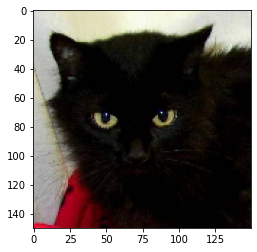

In [16]:
# 画出来这个图片
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [18]:
# 协助可视化的model类，允许多个输出
from keras import models
# 只提取原模型中的前八层
layer_outputs = [layer.output for layer in model.layers[:8]]
layer_outputs

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_3')>]

In [19]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [20]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856 

In [37]:
# 这里返回一个4D张量，第一个维度是层数，后面是每层的输出
activations = activation_model.predict(img_tensor)

8
1
148
148
(148, 32)


# 张量的计算过程
这里以第一层来描述整个张量的计算过程
- 输入的张量大小是(1, 150, 150, 3)，输出的张量大小是(1, 148, 148, 32), 卷积核大小是(3, 3)
- 首先要构建一个4D的卷积核矩阵：先构建32堆，每堆3层，每层的大小是(3, 3)
- 卷积核每移动一次就会产生一个输出，卷积核总共要移动148次
- 每移动一次要做的事情就是：先把三层的卷积结果加起来，再加上本输出通道的偏置
- 所以经过第一层的计算，输出的张量大小是(1, 148, 148, 32)

In [38]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


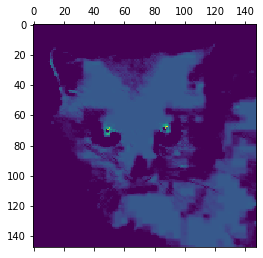

In [41]:
# 总共有32个通道做输出，每个通道都是一个图片
# 看一下其中一个通道的输出
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

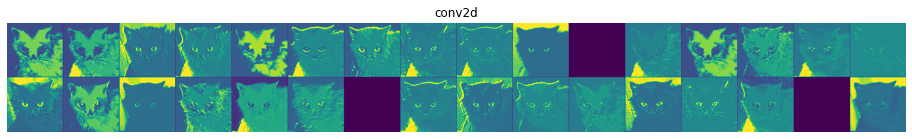

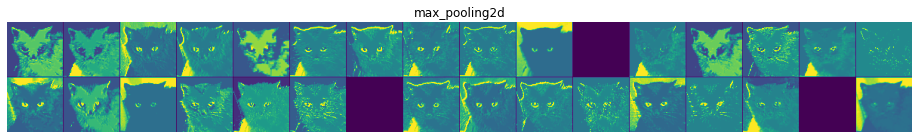

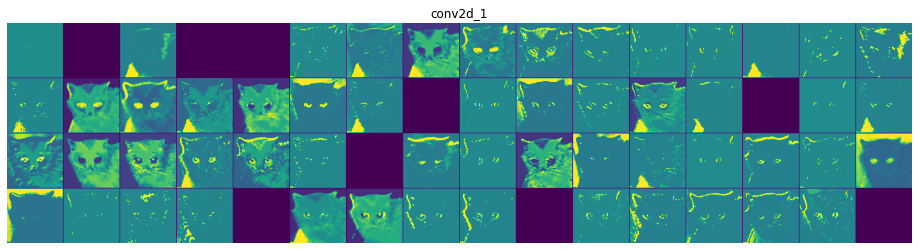

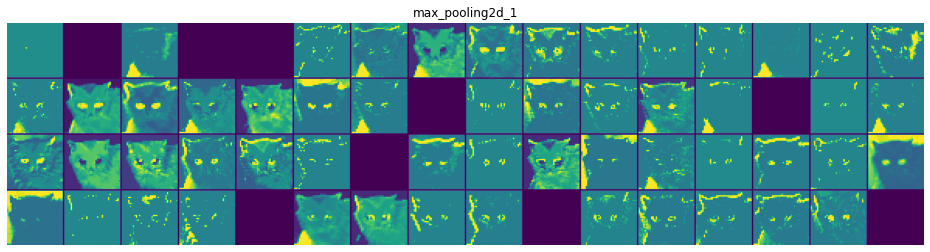

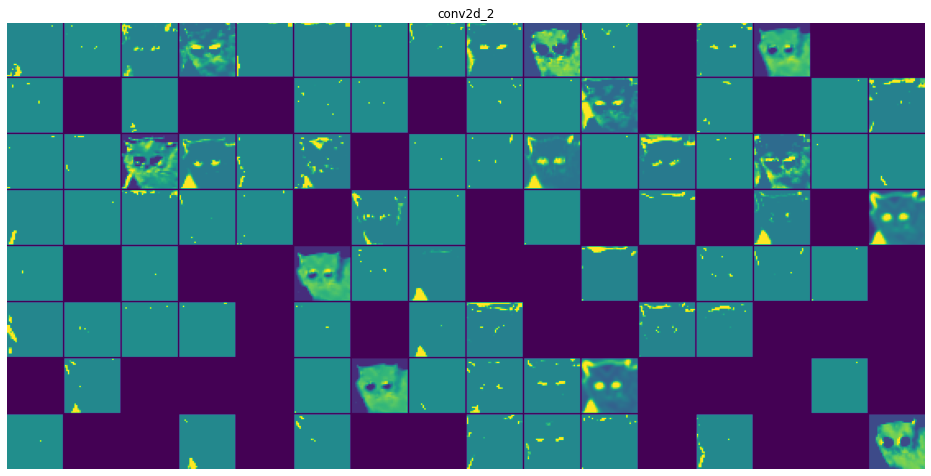

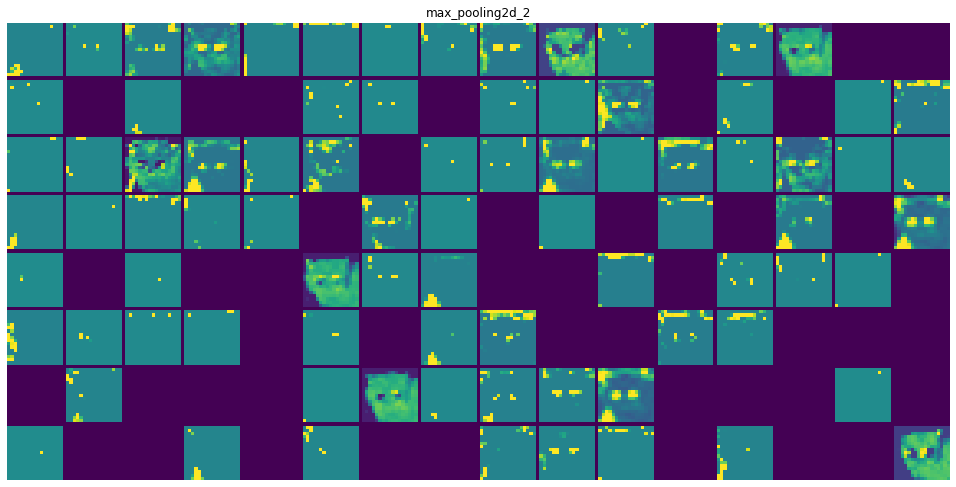

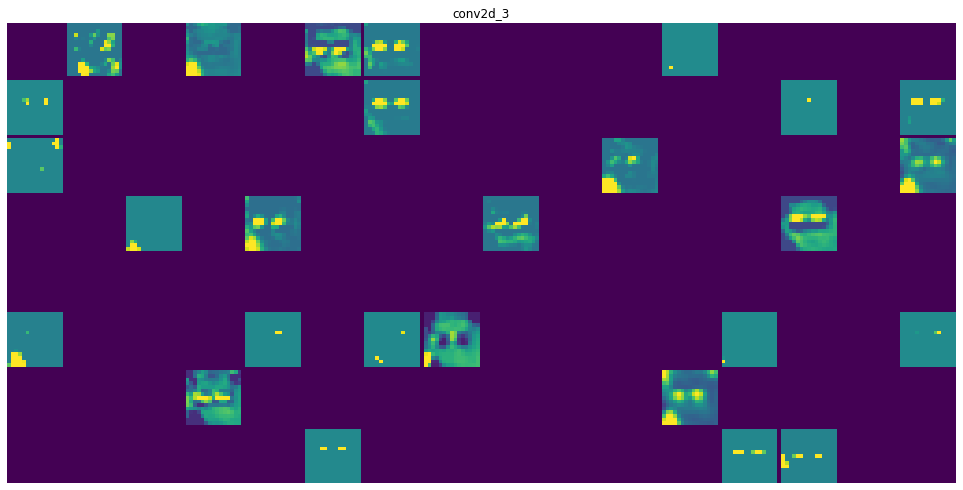

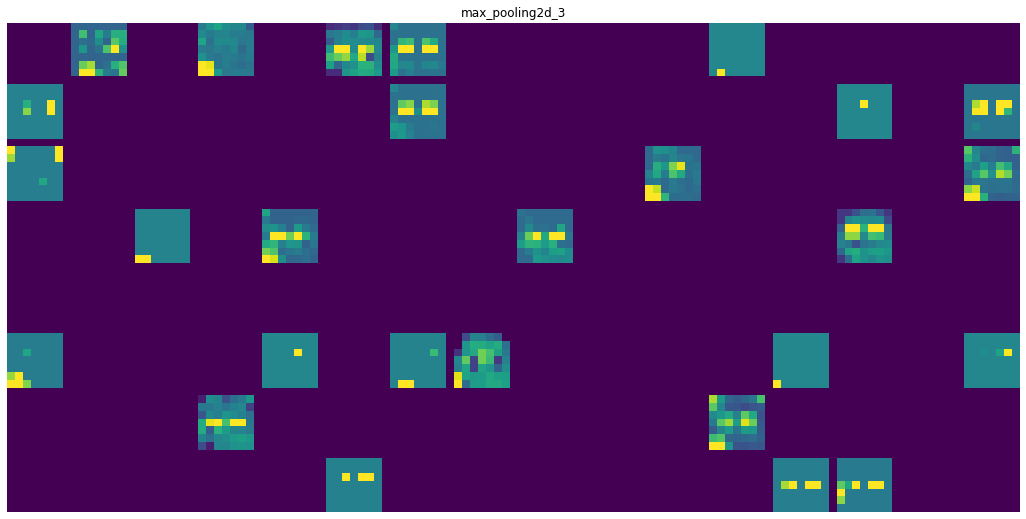

In [49]:
images_per_row = 16
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")